In [2]:
import baostock as bs
from backtrader import feed
import backtrader as bt
import pyfolio as pf
import pandas
baostock_day_k_fields = ','.join(["date","code","open","high","low","close","preclose","volume","amount",
                                  "adjustflag","turn",'tradestatus','pctChg','isST'])
index_day_k_fields = ','.join(["date","code","open","high","low","close","preclose","volume","amount",
                                  "adjustflag","turn",'pctChg'])

C:\Users\12775\Anaconda3\envs\Quant_BackTrader\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
bs.login()


login success!


In [4]:

# stock_list = ['sh.000001']
stock = 'sz.002241'

day_data = bs.query_history_k_data_plus(code=stock, fields=baostock_day_k_fields,
                                        start_date='2020-01-01', end_date="2021-04-28",
                                        frequency='d', adjustflag='1')

SzIndex_data = bs.query_history_k_data_plus(code="sz.399106", fields=baostock_day_k_fields,
                                        start_date='2020-01-01', end_date="2021-04-28",
                                        frequency='d', adjustflag='1')

data_df = day_data.get_data()
sz_df = SzIndex_data.get_data()


In [5]:
sz_df.head()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST
0,2020-01-02,sz.399106,1734.6310,1758.3360,1730.1580,1756.1620,1722.9450,39279517440,424335171584.0000,3,2.280401,1,1.927920,0
1,2020-01-03,sz.399106,1759.7720,1764.5850,1750.1800,1760.8530,1756.1620,37360393728,405390004224.0000,3,2.168985,1,0.267117,0
2,2020-01-06,sz.399106,1751.2510,1782.3240,1747.3460,1768.6830,1760.8530,43899825152,472875864064.0000,3,2.548834,1,0.444671,0
3,2020-01-07,sz.399106,1771.9490,1791.8520,1771.9270,1791.8520,1768.6830,41449962752,444165763072.0000,3,0.000000,1,1.309958,0
4,2020-01-08,sz.399106,1783.5970,1793.7200,1765.1530,1769.5830,1791.8520,46250691072,472740642816.0000,3,2.680005,1,-1.242792,0


In [6]:
class MyPandasData(bt.feeds.PandasData):

    params = (

        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', 'date'),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', 'openinterest'),
    )

    datafields = [
        'date', 'open', 'high', 'low', 'close', 'volume', 'openinterest'
    ]

    def __init__(self):
        super().__init__()

class my_strategy1(bt.Strategy):
    #全局设定交易策略的参数
    params=(
        ('maperiod',20),
           )

    def __init__(self):
        #指定价格序列
        
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #添加移动均线指标，内置了talib模块
        self.sma = bt.indicators.SimpleMovingAverage(
                      self.datas[0], period=self.params.maperiod)
    def next(self):
        if self.order: # 检查是否有指令等待执行,
            return
        # 检查是否持仓
        if not self.position: # 没有持仓
            #执行买入条件判断：收盘价格上涨突破20日均线
            if self.dataclose[0] > self.sma[0]:
                #执行买入
                self.order = self.buy(size=500)
        else:
            #执行卖出条件判断：收盘价格跌破20日均线
            if self.dataclose[0] < self.sma[0]:
                #执行卖出
                self.order = self.sell(size=500)



In [7]:
data_df.info()
sz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         320 non-null    object
 1   code         320 non-null    object
 2   open         320 non-null    object
 3   high         320 non-null    object
 4   low          320 non-null    object
 5   close        320 non-null    object
 6   preclose     320 non-null    object
 7   volume       320 non-null    object
 8   amount       320 non-null    object
 9   adjustflag   320 non-null    object
 10  turn         320 non-null    object
 11  tradestatus  320 non-null    object
 12  pctChg       320 non-null    object
 13  isST         320 non-null    object
dtypes: object(14)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date 

In [8]:
dataframe= data_df
dataframe[['open','high','low','close','preclose','volume','amount','adjustflag','turn','tradestatus','pctChg','isST']]= dataframe[['open','high','low','close','preclose','volume','amount','adjustflag','turn','tradestatus','pctChg','isST']].apply(pandas.to_numeric)
dataframe['openinterest']= 0
dataframe['date']= pandas.to_datetime(dataframe['date'])

cerebro = bt.Cerebro()
cerebro.addstrategy(my_strategy1)
data = MyPandasData(dataname=dataframe)
cerebro.adddata(data)
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(commission=0.002)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
portvalue = cerebro.broker.getvalue()
print('总资金:{}'.format(portvalue))
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')


总资金:1175218.1137144798


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.36,2020-10-29,2021-03-24,NaT,NaN
1,12.94,2020-02-25,2020-03-23,2020-06-23,86
2,5.49,2020-08-03,2020-08-11,2020-08-24,16
3,4.52,2020-09-02,2020-09-09,2020-10-26,39
4,4.36,2020-07-13,2020-07-16,2020-07-23,9


C:\Users\12775\Anaconda3\envs\Quant_BackTrader\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\12775\Anaconda3\envs\Quant_BackTrader\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.06%,-3.70%,3.65%


Top 10 long positions of all time,max
Data0,42.50%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data0,42.50%


C:\Users\12775\Anaconda3\envs\Quant_BackTrader\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


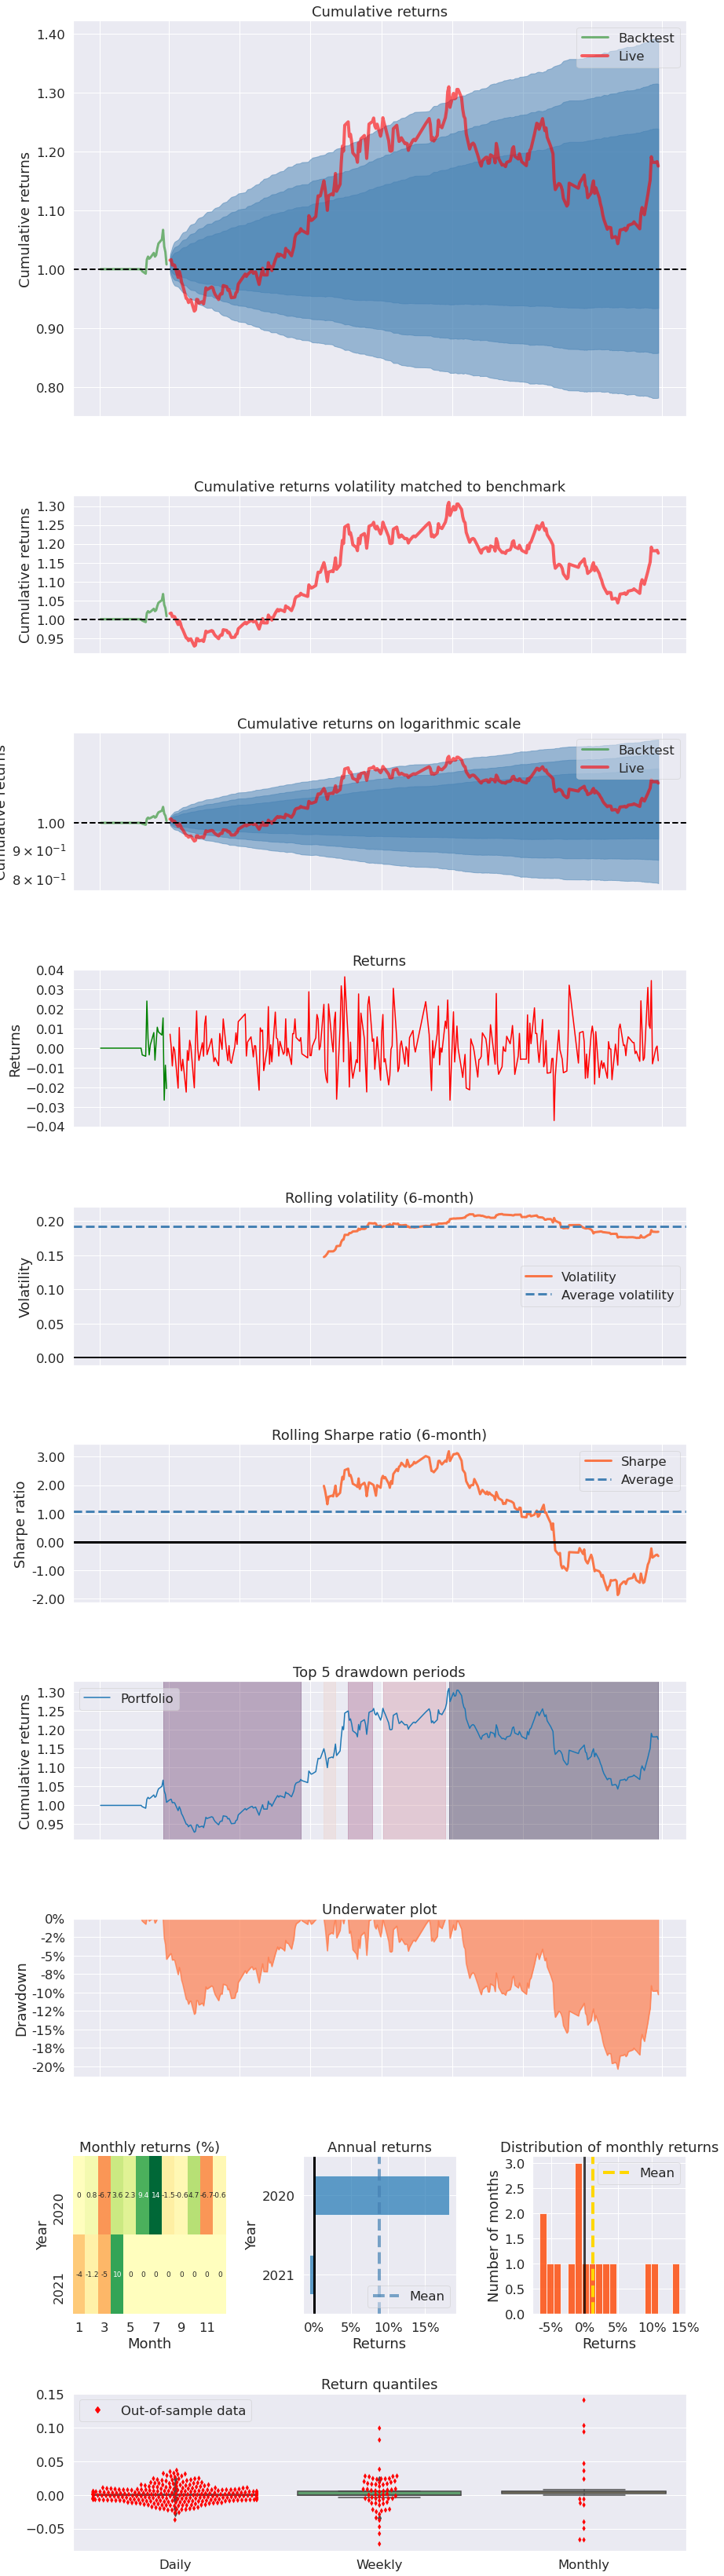

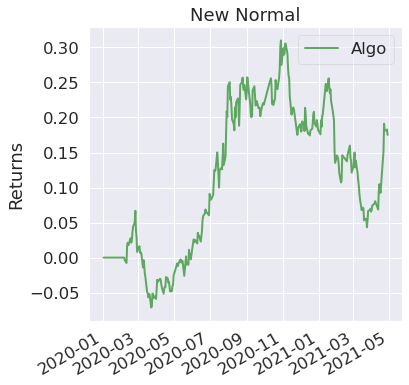

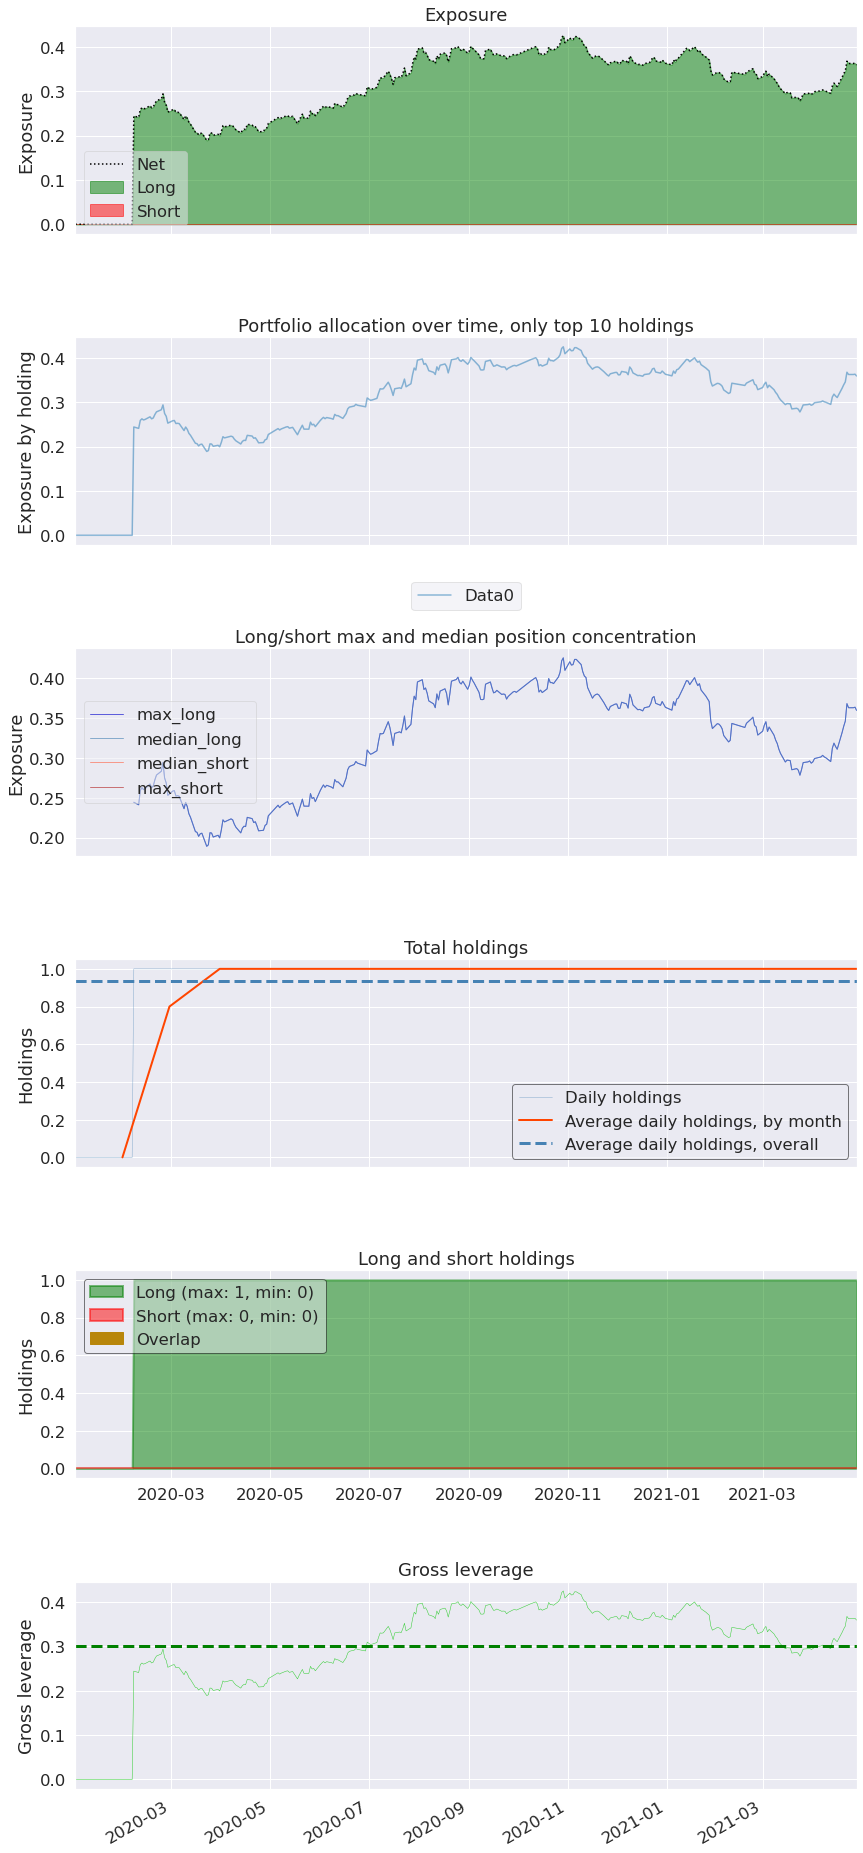

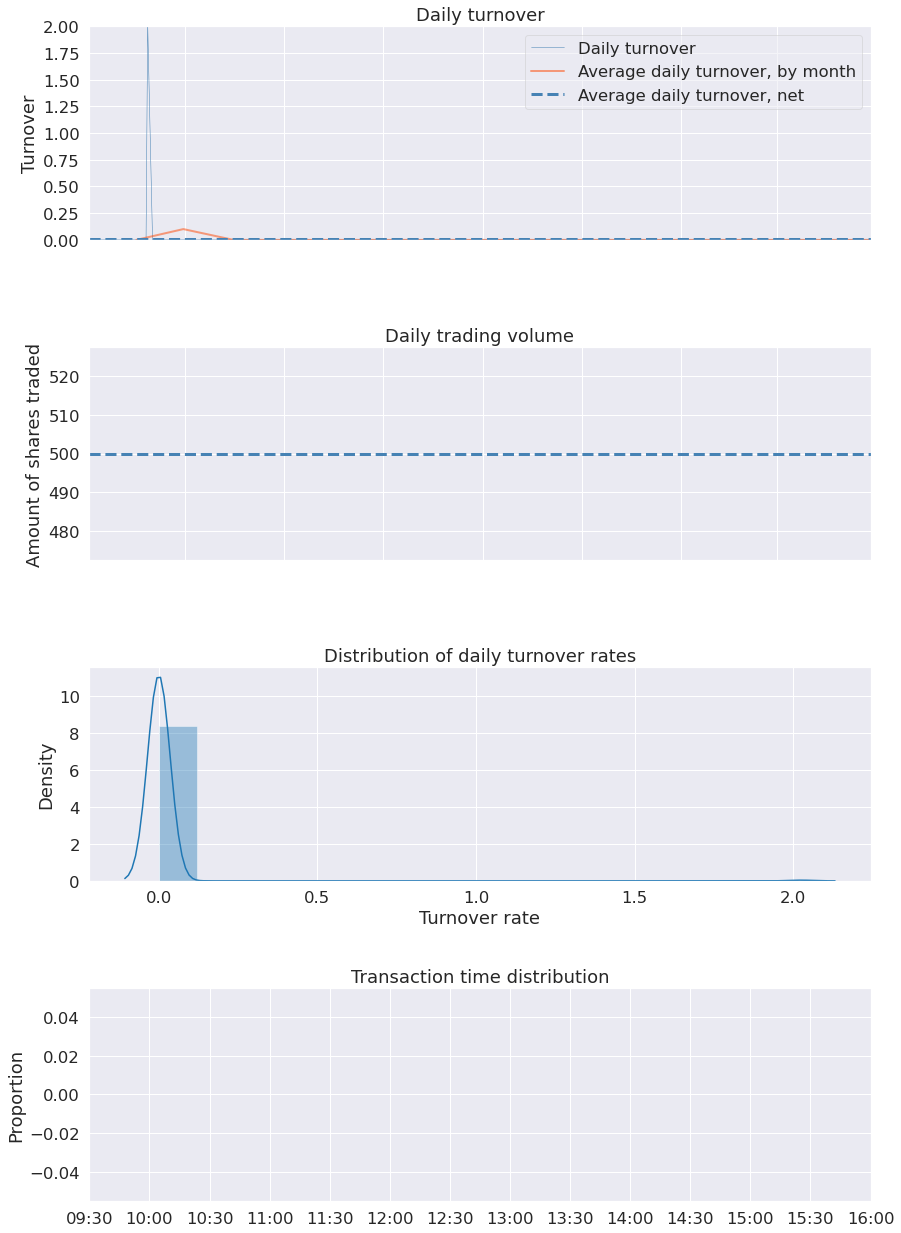

In [9]:

returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
# pyfolio showtime
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date='2020-03-02',  
  )




In [20]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          320 non-null    datetime64[ns]
 1   code          320 non-null    object        
 2   open          320 non-null    float64       
 3   high          320 non-null    float64       
 4   low           320 non-null    float64       
 5   close         320 non-null    float64       
 6   preclose      320 non-null    float64       
 7   volume        320 non-null    int64         
 8   amount        320 non-null    float64       
 9   adjustflag    320 non-null    int64         
 10  turn          320 non-null    float64       
 11  tradestatus   320 non-null    int64         
 12  pctChg        320 non-null    float64       
 13  isST          320 non-null    int64         
 14  openinterest  320 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(

In [16]:
sz_df[['open','high','low','close','preclose','volume','amount','adjustflag','turn','tradestatus','pctChg','isST']]= sz_df[['open','high','low','close','preclose','volume','amount','adjustflag','turn','tradestatus','pctChg','isST']].apply(pandas.to_numeric)

In [33]:
sz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         320 non-null    object 
 1   code         320 non-null    object 
 2   open         320 non-null    float64
 3   high         320 non-null    float64
 4   low          320 non-null    float64
 5   close        320 non-null    float64
 6   preclose     320 non-null    float64
 7   volume       320 non-null    int64  
 8   amount       320 non-null    float64
 9   adjustflag   320 non-null    int64  
 10  turn         320 non-null    float64
 11  tradestatus  320 non-null    int64  
 12  pctChg       320 non-null    float64
 13  isST         320 non-null    int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 35.1+ KB


In [34]:
new_df= pandas.DataFrame()
new_df["stock_change"]= dataframe["turn"]
new_df["index_change"]= sz_df["turn"]

In [48]:
new_df.head()

,stock_change,index_change
0,2.2368,2.280401
1,2.0782,2.168985
2,2.7632,2.548834
3,3.4316,0.000000
4,1.4219,2.680005


In [51]:
new_df.corr()


,stock_change,index_change
stock_change,1.000000,0.261505
index_change,0.261505,1.000000


In [24]:
df_stand = new_df.apply()
df_stand.head()

0    0.271549
1    0.267211
2    0.268865
3    0.221513
4    0.413074
dtype: float64